# Summary

Model parameters summary:

Model with spectral normalization in all the last two residual block layers (ResBlock3 & ResBlock 4)

-   model_name: resnet18
-   input_channels: 3
-   **spectral_norm: true**
-   **drop_block: true**
-   **dropblock_prob: 0.5**
-   **dropblock_block_size: 6**
-   **dropout: false**
-   **dropout_prob: 0.3**
-   lr: 0.0001
-   weight_decay: 0.0001
-   loss_type: focal

**Results:**

Experiment: gtsrb vs gtsrb-anomal 

- AUROC: 0.8444
- FPR95: 0.5883
- AUPR: 0.8301

Experiment: gtsrb vs cifar10

- AUROC: 0.9739
- FPR95: 0.1394
- AUPR: 0.9492

Experiment: gtsrb vs stl10

- AUROC: 0.9837
- FPR95: 0.0625

# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
from datasets import GtsrbModule

In [6]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [7]:
from models import ResnetModule

In [8]:
from dropblock import DropBlock2D, LinearScheduler

In [9]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier
from ls_ood_detect_cea.metrics import get_ood_detector_results, plot_roc_ood_detector

# Paths

Datasets paths:

In [10]:
gtsrb_dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"
cifar10_data_path = "/media/farnez/Data/DATASETS/cifar-10/"
stl10_data_path = "/media/farnez/Data/DATASETS/stl-10/"

Experiments path:

In [11]:
exp_path = "/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/"

Resnet Classification Model Number & checkpoint:

In [12]:
exp_model_name = "resnet18_model_9"

In [13]:
gtsrb_resnet18_model_path = exp_path + exp_model_name + "/model/last.ckpt"
gtsrb_resnet18_model_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/resnet18_model_9/model/last.ckpt'

Samples Paths:

In [14]:
mc_samples_path = exp_path + exp_model_name + "/embeddings_z/mc_samples/"
mc_samples_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/resnet18_model_9/embeddings_z/mc_samples/'

In [15]:
h_z_path = exp_path + exp_model_name + "/embeddings_z/entropy/"
h_z_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/resnet18_model_9/embeddings_z/entropy/'

# Compute Device

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Datasets

## GTSRB-Normal

In [21]:
gtsrb_normal_dm = GtsrbModule(img_size=(128, 128), data_path=gtsrb_dataset_path, batch_size=1, shuffle=False)

In [22]:
gtsrb_normal_dm.setup(stage='fit')
gtsrb_normal_dm.setup(stage='validate')
gtsrb_normal_dm.setup(stage='test')

In [23]:
gtsrb_ds_len = len(gtsrb_normal_dm.ds_gtsrb_train)
indices_train_dl = list(range(gtsrb_ds_len))
samples_size = 0.2 # of the dataset

random.seed(9290)
random.shuffle(indices_train_dl)

split = int(np.floor(gtsrb_ds_len * samples_size))
samples_idx = indices_train_dl[:split]
ic(len(samples_idx));

train_sampler = SubsetRandomSampler(samples_idx)

gtsrb_normal_dm.shuffle = False
gtsrb_normal_dm.ds_gtsrb_train_sampler = train_sampler

ic| len(samples_idx): 7120


In [24]:
gtsrb_normal_train_loader = gtsrb_normal_dm.train_dataloader()
gtsrb_normal_valid_loader = gtsrb_normal_dm.val_dataloader()
gtsrb_normal_test_loader = gtsrb_normal_dm.test_dataloader()
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));

ic| len(gtsrb_normal_train_loader): 7120


ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273


In [29]:
dataiter = iter(gtsrb_normal_train_loader)

No entry


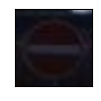

In [30]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_normal_dm.idx2label[lbl_np.item()])
gtsrb_normal_dm.unprocess_image(samp[0], plot=True)

## GTSRB-Anomalies

In [31]:
gtsrb_anomal_dm = GtsrbModule(img_size=(128, 128), data_path=gtsrb_dataset_path, batch_size=1, anomaly_transforms=True, shuffle=True)

In [32]:
gtsrb_anomal_dm.setup(stage='fit')
gtsrb_anomal_dm.setup(stage='validate')
gtsrb_anomal_dm.setup(stage='test')

In [33]:
gtsrb_anomal_train_loader = gtsrb_anomal_dm.train_dataloader()
gtsrb_anomal_valid_loader = gtsrb_anomal_dm.val_dataloader()
gtsrb_anomal_test_loader = gtsrb_anomal_dm.test_dataloader()
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));

ic| len(gtsrb_anomal_train_loader): 35600


ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273


In [34]:
dataiter_anomal = iter(gtsrb_anomal_train_loader)

Wild animals crossing


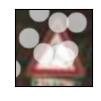

In [39]:
samp, lbl = dataiter_anomal.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_anomal_dm.idx2label[lbl_np.item()])
gtsrb_anomal_dm.unprocess_image(samp[0], plot=True)

## CIFAR-10 OoD

In [40]:
cifar10_dm = CIFAR10DataModule(data_dir=cifar10_data_path,
                               val_split=0.2,
                               num_workers=10,
                               normalize=True,
                               batch_size=1,
                               seed=10,
                               drop_last=True,
                               shuffle=True)

cifar10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=[0.3337, 0.3064, 0.3171],
        std=[0.2672, 0.2564, 0.2629]
    )
])

cifar10_dm.train_transforms = cifar10_transforms
cifar10_dm.test_transforms = cifar10_transforms
cifar10_dm.val_transforms  = cifar10_transforms

In [41]:
# cifar10_dm.prepare_data()

In [42]:
cifar10_dm.setup(stage='fit')
cifar10_dm.setup(stage='test')

In [43]:
cifar10_train_loader = cifar10_dm.train_dataloader()
cifar10_valid_loader = cifar10_dm.val_dataloader()
cifar10_test_loader = cifar10_dm.test_dataloader()
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));

ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000


In [44]:
def unprocess_cifar10_image(im,
                            norm_mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                            norm_std=[x / 255.0 for x in [63.0, 62.1, 66.7]], 
                            plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [45]:
dataiter = iter(cifar10_train_loader)

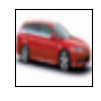

In [46]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_cifar10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

## STL-10 OoD

In [47]:
stl10_dm = STL10DataModule(data_dir=stl10_data_path,
                           train_val_split=3000,
                           num_workers=10,
                           batch_size=1,
                           seed=10,
                           drop_last=True,
                           shuffle=True)

stl10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=(0.3337, 0.3064, 0.3171),
        std=(0.2672, 0.2564, 0.2629)
    )
])

stl10_dm.train_transforms = stl10_transforms
stl10_dm.test_transforms = stl10_transforms
stl10_dm.val_transforms  = stl10_transforms

In [48]:
# stl10_dm.prepare_data()

In [49]:
stl10_train_loader = stl10_dm.train_dataloader_labeled()
stl10_valid_loader = stl10_dm.val_dataloader_labeled()
stl10_test_loader = stl10_dm.test_dataloader()
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(stl10_train_loader): 2000
ic| len(stl10_valid_loader): 3000
ic| len(stl10_test_loader): 8000


In [50]:
def unprocess_stl10_image(im,
                          norm_mean=[0.43, 0.42, 0.39],
                          norm_std=[0.27, 0.26, 0.27], 
                          plot=False):

    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [51]:
dataiter = iter(stl10_train_loader)

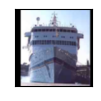

In [52]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_stl10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

# GTSRB ResNet18 Classifier

In [53]:
gtsrb_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_resnet18_model_path)

In [56]:
gtsrb_model;

In [55]:
gtsrb_model.eval();

# Add Hook

We add 2 Hooks:

1. In the dropblock2d layer (after applying dropout to the)
2. In the fc (after applying a linear transformation to the output of the dropblock2d layer)

In [57]:
ic(gtsrb_model.model.dropblock2d_layer);
ic(gtsrb_model.model.dropblock2d_layer.drop_prob);
ic(gtsrb_model.model.dropblock2d_layer.block_size);
ic(gtsrb_model.model.dropblock2d_layer.training);
ic("===========================");
ic(gtsrb_model.model.dropout_layer);
ic(gtsrb_model.model.dropout_layer.p);
ic(gtsrb_model.model.dropout_layer.training);

ic| 

gtsrb_model.model.dropblock2d_layer: DropBlock2D()
ic| gtsrb_model.model.dropblock2d_layer.drop_prob: 0.5
ic| gtsrb_model.model.dropblock2d_layer.block_size: 6
ic| gtsrb_model.model.dropblock2d_layer.training: False
ic| '==========================='
ic| gtsrb_model.model.dropout_layer: Dropout(p=0.3, inplace=False)
ic| gtsrb_model.model.dropout_layer.p: 0.3
ic| gtsrb_model.model.dropout_layer.training: False


## Hook DropBlock2D Layer

In [58]:
gtsrb_model_dropblock2d_layer_hook = Hook(gtsrb_model.model.dropblock2d_layer)

In [59]:
ic(gtsrb_model.model.dropblock2d_layer._forward_hooks);

ic| gtsrb_model.model.dropblock2d_layer.

_forward_hooks: OrderedDict([(74,
                                                                      <bound method Hook.hook_fn of <ls_ood_detect_cea.uncertainty_estimation.Hook object at 0x7f7a752ec4d0>>)])


# Get Monte-Carlo Samples

In [60]:
# Monte Carlo Dropout - Enable Dropout @ Test Time!
def resnet18_enable_dropblock2d_test(m):
    if type(m) == DropBlock2D:
        m.train()

In [25]:
mc_samples = 16

In [62]:
gtsrb_model.to(device);
gtsrb_model.eval(); 
gtsrb_model.apply(resnet18_enable_dropblock2d_test); # enable dropout

In [63]:
ic(gtsrb_model.model.dropblock2d_layer);
ic(gtsrb_model.model.dropblock2d_layer.drop_prob);
ic(gtsrb_model.model.dropblock2d_layer.block_size);
ic(gtsrb_model.model.dropblock2d_layer.training);
ic("=======");
ic(gtsrb_model.model.dropout_layer);
ic(gtsrb_model.model.dropout_layer.p);
ic(gtsrb_model.model.dropout_layer.training);

ic| gtsrb_model.model.dropblock2d_layer: DropBlock2D()
ic| gtsrb_model.model.dropblock2d_layer.drop_prob: 0.5
ic| gtsrb_model.

model.dropblock2d_layer.block_size: 6
ic| gtsrb_model.model.dropblock2d_layer.training: True
ic| '======='
ic| gtsrb_model.model.dropout_layer: Dropout(p=0.3, inplace=False)
ic| gtsrb_model.model.dropout_layer.p: 0.3
ic| gtsrb_model.model.dropout_layer.training: False


In [64]:
gtsrb_resnet_gtsrb_normal_train_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                                gtsrb_normal_train_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [65]:
gtsrb_resnet_gtsrb_normal_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                                gtsrb_normal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [66]:
gtsrb_resnet_gtsrb_normal_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                               gtsrb_normal_test_loader,
                                                                               mc_samples,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=True)

In [67]:
gtsrb_resnet_gtsrb_anomal_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                                gtsrb_anomal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [68]:
gtsrb_resnet_gtsrb_anomal_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                               gtsrb_anomal_test_loader,
                                                                               mc_samples,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=True)

In [69]:
gtsrb_resnet_cifar10_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                           cifar10_valid_loader,
                                                                           mc_samples,
                                                                           gtsrb_model_dropblock2d_layer_hook,
                                                                           get_2d_rep_mean=True)

In [70]:
gtsrb_resnet_cifar10_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                          cifar10_test_loader,
                                                                          mc_samples,
                                                                          gtsrb_model_dropblock2d_layer_hook,
                                                                          get_2d_rep_mean=True)

In [71]:
gtsrb_resnet_stl10_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                         stl10_valid_loader,
                                                                         mc_samples,
                                                                         gtsrb_model_dropblock2d_layer_hook,
                                                                         get_2d_rep_mean=True)

In [72]:
gtsrb_resnet_stl10_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                        stl10_test_loader,
                                                                        mc_samples,
                                                                        gtsrb_model_dropblock2d_layer_hook,
                                                                        get_2d_rep_mean=True)

In [73]:
mc_samples_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/resnet18_model_9/embeddings_z/mc_samples/'

In [74]:
torch.save(gtsrb_resnet_gtsrb_normal_train_16mc_samples,
           mc_samples_path + "gtsrb_resnet_gtsrb_normal_train_16mc_samples.pt")

In [75]:
torch.save(gtsrb_resnet_gtsrb_normal_valid_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_gtsrb_normal_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_normal_test_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_gtsrb_normal_test_16mc_samples.pt')

In [76]:
torch.save(gtsrb_resnet_gtsrb_anomal_valid_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_gtsrb_anomal_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_anomal_test_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_gtsrb_anomal_test_16mc_samples.pt')

In [77]:
torch.save(gtsrb_resnet_cifar10_valid_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_cifar10_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_cifar10_test_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_cifar10_test_16mc_samples.pt')

In [78]:
torch.save(gtsrb_resnet_stl10_valid_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_stl10_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_stl10_test_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_stl10_test_16mc_samples.pt')

In [20]:
gtsrb_resnet_gtsrb_normal_train_16mc_samples = torch.load(mc_samples_path + "gtsrb_resnet_gtsrb_normal_train_16mc_samples.pt")

gtsrb_resnet_gtsrb_normal_valid_16mc_samples = torch.load(mc_samples_path + 'gtsrb_resnet_gtsrb_normal_valid_16mc_samples.pt')
gtsrb_resnet_gtsrb_normal_test_16mc_samples = torch.load(mc_samples_path + 'gtsrb_resnet_gtsrb_normal_test_16mc_samples.pt')

gtsrb_resnet_gtsrb_anomal_valid_16mc_samples = torch.load(mc_samples_path + 'gtsrb_resnet_gtsrb_anomal_valid_16mc_samples.pt')
gtsrb_resnet_gtsrb_anomal_test_16mc_samples = torch.load(mc_samples_path + 'gtsrb_resnet_gtsrb_anomal_test_16mc_samples.pt')

gtsrb_resnet_cifar10_valid_16mc_samples = torch.load(mc_samples_path + 'gtsrb_resnet_cifar10_valid_16mc_samples.pt')
gtsrb_resnet_cifar10_test_16mc_samples = torch.load(mc_samples_path + 'gtsrb_resnet_cifar10_test_16mc_samples.pt')

gtsrb_resnet_stl10_valid_16mc_samples = torch.load(mc_samples_path + 'gtsrb_resnet_stl10_valid_16mc_samples.pt')
gtsrb_resnet_stl10_test_16mc_samples = torch.load(mc_samples_path + 'gtsrb_resnet_stl10_test_16mc_samples.pt')

# MC Samples Normalized 

In [21]:
ic(gtsrb_resnet_gtsrb_normal_train_16mc_samples.shape);

ic(gtsrb_resnet_gtsrb_normal_valid_16mc_samples.shape);
ic(gtsrb_resnet_gtsrb_normal_test_16mc_samples.shape);

ic(gtsrb_resnet_gtsrb_anomal_valid_16mc_samples.shape);
ic(gtsrb_resnet_gtsrb_anomal_test_16mc_samples.shape);

ic(gtsrb_resnet_cifar10_valid_16mc_samples.shape);
ic(gtsrb_resnet_cifar10_test_16mc_samples.shape);

ic(gtsrb_resnet_stl10_valid_16mc_samples.shape);
ic(gtsrb_resnet_stl10_test_16mc_samples.shape);

ic| gtsrb_resnet_gtsrb_normal_train_16mc_samples.shape: torch.Size([113920, 128])
ic| gtsrb_resnet_gtsrb_normal_valid_16mc_samples.shape: torch.Size([57744, 128])
ic| gtsrb_resnet_gtsrb_normal_test_16mc_samples.shape: torch.Size([20368, 128])
ic| gtsrb_resnet_gtsrb_anomal_valid_16mc_samples.shape: torch.Size([57744, 128])
ic| gtsrb_resnet_gtsrb_anomal_test_16mc_samples.shape: torch.Size([20368, 128])
ic| gtsrb_resnet_cifar10_valid_16mc_samples.shape: torch.Size([160000, 128])
ic| gtsrb_resnet_cifar10_test_16mc_samples.shape: torch.Size([160000, 128])
ic| gtsrb_resnet_stl10_valid_16mc_samples.shape: torch.Size([48000, 128])
ic| gtsrb_resnet_stl10_test_16mc_samples.shape: torch.Size([128000, 128])


In [22]:
gtsrb_resnet_gtsrb_normal_train_16mc_norm_samples = torch.nn.functional.normalize(gtsrb_resnet_gtsrb_normal_train_16mc_samples)

gtsrb_resnet_gtsrb_normal_valid_16mc_norm_samples = torch.nn.functional.normalize(gtsrb_resnet_gtsrb_normal_valid_16mc_samples)
gtsrb_resnet_gtsrb_normal_test_16mc_norm_samples = torch.nn.functional.normalize(gtsrb_resnet_gtsrb_normal_test_16mc_samples)

gtsrb_resnet_gtsrb_anomal_valid_16mc_norm_samples = torch.nn.functional.normalize(gtsrb_resnet_gtsrb_anomal_valid_16mc_samples)
gtsrb_resnet_gtsrb_anomal_test_16mc_norm_samples = torch.nn.functional.normalize(gtsrb_resnet_gtsrb_anomal_test_16mc_samples)

gtsrb_resnet_cifar10_valid_16mc_norm_samples = torch.nn.functional.normalize(gtsrb_resnet_cifar10_valid_16mc_samples)
gtsrb_resnet_cifar10_test_16mc_norm_samples = torch.nn.functional.normalize(gtsrb_resnet_cifar10_test_16mc_samples)

gtsrb_resnet_stl10_valid_16mc_norm_samples = torch.nn.functional.normalize(gtsrb_resnet_stl10_valid_16mc_samples)
gtsrb_resnet_stl10_test_16mc_norm_samples = torch.nn.functional.normalize(gtsrb_resnet_stl10_test_16mc_samples)

In [23]:
ic(gtsrb_resnet_gtsrb_normal_train_16mc_norm_samples.shape);

ic(gtsrb_resnet_gtsrb_normal_valid_16mc_norm_samples.shape);
ic(gtsrb_resnet_gtsrb_normal_test_16mc_norm_samples.shape);

ic(gtsrb_resnet_gtsrb_anomal_valid_16mc_norm_samples.shape);
ic(gtsrb_resnet_gtsrb_anomal_test_16mc_norm_samples.shape);

ic(gtsrb_resnet_cifar10_valid_16mc_norm_samples.shape);
ic(gtsrb_resnet_cifar10_test_16mc_norm_samples.shape);

ic(gtsrb_resnet_stl10_valid_16mc_norm_samples.shape);
ic(gtsrb_resnet_stl10_test_16mc_norm_samples.shape);

ic| gtsrb_resnet_gtsrb_normal_train_16mc_norm_samples.shape: torch.Size([113920, 128])
ic| gtsrb_resnet_gtsrb_normal_valid_16mc_norm_samples.shape: torch.Size([57744, 128])
ic| gtsrb_resnet_gtsrb_normal_test_16mc_norm_samples.shape: torch.Size([20368, 128])
ic| gtsrb_resnet_gtsrb_anomal_valid_16mc_norm_samples.shape: torch.Size([57744, 128])
ic| gtsrb_resnet_gtsrb_anomal_test_16mc_norm_samples.shape: torch.Size([20368, 128])
ic| gtsrb_resnet_cifar10_valid_16mc_norm_samples.shape: torch.Size([160000, 128])
ic| gtsrb_resnet_cifar10_test_16mc_norm_samples.shape: torch.Size([160000, 128])
ic| gtsrb_resnet_stl10_valid_16mc_norm_samples.shape: torch.Size([48000, 128])
ic| gtsrb_resnet_stl10_test_16mc_norm_samples.shape: torch.Size([128000, 128])


# Get Entropy

In [79]:
_, gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_train_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (7120, 1)
ic| dl_h_z_samples_np.shape: (7120, 128)


In [80]:
_, gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_valid_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)


In [81]:
_, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_test_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)


In [82]:
_, gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_valid_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)


In [83]:
_, gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_test_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)


In [84]:
_, gtsrb_rn18_h_z_cifar10_valid_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_valid_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)


In [85]:
_, gtsrb_rn18_h_z_cifar10_test_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_test_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)


In [86]:
_, gtsrb_rn18_h_z_stl10_valid_samples_np = get_dl_h_z(gtsrb_resnet_stl10_valid_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (3000, 1)
ic| dl_h_z_samples_np.shape: (3000, 128)


In [87]:
_, gtsrb_rn18_h_z_stl10_test_samples_np = get_dl_h_z(gtsrb_resnet_stl10_test_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (8000, 1)
ic| dl_h_z_samples_np.shape: (8000, 128)


In [88]:
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_test_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np',
        gtsrb_rn18_h_z_cifar10_valid_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np',
        gtsrb_rn18_h_z_cifar10_test_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np',
        gtsrb_rn18_h_z_stl10_valid_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np',
        gtsrb_rn18_h_z_stl10_test_samples_np)

# Load Entropy Values

In [89]:
gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np.npy')

In [91]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);


ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)


ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


# Get Entropy from Normalized MC Samples

In [ ]:
ic(gtsrb_resnet_gtsrb_normal_train_16mc_norm_samples.shape);

ic(gtsrb_resnet_gtsrb_normal_valid_16mc_norm_samples.shape);
ic(gtsrb_resnet_gtsrb_normal_test_16mc_norm_samples.shape);

ic(gtsrb_resnet_gtsrb_anomal_valid_16mc_norm_samples.shape);
ic(gtsrb_resnet_gtsrb_anomal_test_16mc_norm_samples.shape);

ic(gtsrb_resnet_cifar10_valid_16mc_norm_samples.shape);
ic(gtsrb_resnet_cifar10_test_16mc_norm_samples.shape);

ic(gtsrb_resnet_stl10_valid_16mc_norm_samples.shape);
ic(gtsrb_resnet_stl10_test_16mc_norm_samples.shape);

In [28]:
_, gtsrb_rn18_h_z_cifar10_test_norm_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_test_16mc_norm_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)


In [26]:
_, gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_train_16mc_norm_samples, mcd_samples_nro=mc_samples)
_, gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_valid_16mc_norm_samples, mcd_samples_nro=mc_samples)
_, gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_test_16mc_norm_samples, mcd_samples_nro=mc_samples)

_, gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_valid_16mc_norm_samples, mcd_samples_nro=mc_samples)
_, gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_test_16mc_norm_samples, mcd_samples_nro=mc_samples)

_, gtsrb_rn18_h_z_cifar10_valid_norm_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_valid_16mc_norm_samples, mcd_samples_nro=mc_samples)
_, gtsrb_rn18_h_z_cifar10_test_norm_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_test_16mc_norm_samples, mcd_samples_nro=mc_samples)

_, gtsrb_rn18_h_z_stl10_valid_norm_samples_np = get_dl_h_z(gtsrb_resnet_stl10_valid_16mc_norm_samples, mcd_samples_nro=mc_samples)
_, gtsrb_rn18_h_z_stl10_test_norm_samples_np = get_dl_h_z(gtsrb_resnet_stl10_test_16mc_norm_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (7120, 1)
ic| dl_h_z_samples_np.shape: (7120, 128)
ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)
ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)
ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)
ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)
ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)
ic| dl_h_mvn_z_samples_np.shape: (8000, 1)
ic| dl_h_z_samples_np.shape: (8000, 128)
ic| dl_h_mvn_z_samples_np.shape: (3000, 1)
ic| dl_h_z_samples_np.shape: (3000, 128)
ic| dl_h_mvn_z_samples_np.shape: (8000, 1)
ic| dl_h_z_samples_np.shape: (8000, 128)


In [27]:
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_norm_samples_np',
        gtsrb_rn18_h_z_cifar10_valid_norm_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_norm_samples_np',
        gtsrb_rn18_h_z_cifar10_test_norm_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_norm_samples_np',
        gtsrb_rn18_h_z_stl10_valid_norm_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_stl10_test_norm_samples_np',
        gtsrb_rn18_h_z_stl10_test_norm_samples_np)